<a href="https://colab.research.google.com/github/S3nnar/CC-SQS-Method-Repo/blob/main/PML1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Der vorliegende Code implementiert einen Naive-Bayes-Klassifikator zur Klassifikation medizinischer Daten und verwendet einen Datensatz, der Informationen über Entzündungen und Nephritis (Nierenentzündungen) enthält. Der Code trainiert den Klassifikator anhand eines Teils der Daten und bewertet die Genauigkeit der Vorhersagen anhand eines separaten Testdatensatzes. Die Performance des Modells wird abschließend mittels einer Confusion Matrix visualisiert.

Der Naive-Bayes-Klassifikator ist ein einfaches, aber leistungsstarkes Modell, das auf dem Bayes-Theorem basiert. Das Modell schätzt die Wahrscheinlichkeit, dass ein Datenpunkt einer bestimmten Klasse angehört, basierend auf den Werten seiner Merkmale. Eine wichtige Annahme dieses Modells ist die Unabhängigkeit der Merkmale, d.h., dass jedes Merkmal unabhängig von den anderen zur Klassifikation beiträgt (daher "naiv").

Das Bayes-Theorem lautet wie folgt:
$$ P(A|B) = \frac{P(B|A) \cdot P(A)}{P(B)} $$


In diesem Zusammenhang steht:

  P(A∣B) für die Wahrscheinlichkeit, dass die Klasse A (z.B. "Entzündung vorhanden") vorliegt, wenn die Merkmale B (z.B. Fieber, Schmerzen usw.) beobachtet werden.\
  P(B∣A) ist die Wahrscheinlichkeit, die Merkmale B zu sehen, wenn die Klasse A vorliegt.\
  P(A) ist die a-priori Wahrscheinlichkeit der Klasse A (wie häufig tritt die Klasse auf).\
  P(B) ist die Wahrscheinlichkeit, die Merkmale B zu sehen.​

Der Konstruktor der Klasse initialisiert die Variablen, die während des Trainings und der Vorhersagen verwendet werden.

  prior_probs: Speichert die a-priori Wahrscheinlichkeiten jeder Klasse. Diese geben an, wie wahrscheinlich es ist, dass ein Datenpunkt zu einer bestimmten Klasse gehört, ohne die Merkmale zu berücksichtigen.

  conditional_probs: Speichert die bedingten Wahrscheinlichkeiten für jede Kombination aus Merkmal und Klasse. Dies sind die Wahrscheinlichkeiten, dass ein bestimmter Wert eines Merkmals in einer bestimmten Klasse auftritt.

  classes: Speichert die eindeutigen Klassen, die im Zielwert (y) vorhanden sind.

In [1]:
# Diese Klasse wird hier im ganzen angegeben, damit die Methoden der Klasse zugeordnet werden.
# Weiter unten folgen die Erklärungen für die einzelnen Methoden.
import pandas as pd
import math

class NaiveBayes:
    def __init__(self):
        # Initialisierung der Wahrscheinlichkeiten und Klassen
        self.prior_probs = {}         # A-priori Wahrscheinlichkeiten für jede Klasse
        self.conditional_probs = {}   # Bedingte Wahrscheinlichkeiten für jedes Feature in jeder Klasse
        self.classes = []             # Liste der vorhandenen Klassen

    # Die fit-Methode trainiert den Naive-Bayes-Klassifikator
    # Sie berechnet die a-priori Wahrscheinlichkeiten und die bedingten Wahrscheinlichkeiten
    def fit(self, X, y):
        # Speichern der eindeutigen Klassen (True/False oder andere)
        self.classes = y.unique()

        # Berechnung der a-priori Wahrscheinlichkeiten für jede Klasse
        for class_label in self.classes:
            # Anzahl der Vorkommen der Klasse class_label
            class_count = (y == class_label).sum()
            # A-priori Wahrscheinlichkeit der Klasse class_label
            self.prior_probs[class_label] = class_count / len(y)

            # Berechnung der bedingten Wahrscheinlichkeiten für jede Feature-Spalte
            self.conditional_probs[class_label] = {}
            for column in X.columns:
                self.conditional_probs[class_label][column] = {}

                # Alle möglichen Werte des Features (z.B. ja/nein, Temperaturwerte)
                feature_values = X[column].unique()
                for value in feature_values:
                    # Anzahl der Vorkommen des Wertes 'value' in der Klasse 'class_label'
                    feature_class_count = ((X[column] == value) & (y == class_label)).sum()
                    # Bedingte Wahrscheinlichkeit für das Feature gegeben die Klasse
                    self.conditional_probs[class_label][column][value] = feature_class_count / class_count

    # Die predict_probability-Methode berechnet die Wahrscheinlichkeiten jeder Klasse
    # für jeden Datenpunkt in X, basierend auf den bedingten Wahrscheinlichkeiten und der a-priori Wahrscheinlichkeit.
    def predict_probability(self, X):
        predictions = []  # Liste, die die Wahrscheinlichkeiten für jede Klasse speichert

        # Iteriere über jede Zeile in den Eingabedaten
        for index, row in X.iterrows():
            class_probs = {}  # Dictionary, um Wahrscheinlichkeiten für jede Klasse zu speichern
            for class_label in self.classes:
                # Beginne mit der a-priori Wahrscheinlichkeit der Klasse
                class_probs[class_label] = self.prior_probs[class_label]

                # Multipliziere die a-priori Wahrscheinlichkeit mit den bedingten Wahrscheinlichkeiten für jedes Feature
                for column in X.columns:
                    feature_value = row[column]
                    if feature_value in self.conditional_probs[class_label][column]:
                        # Multipliziere mit der bedingten Wahrscheinlichkeit
                        class_probs[class_label] *= self.conditional_probs[class_label][column][feature_value]
                    else:
                        # Falls der Wert im Trainingssatz nicht vorkam, multipliziere mit einer kleinen Wahrscheinlichkeit
                        class_probs[class_label] *= 1e-6  # Glättung
            # Füge die Wahrscheinlichkeiten des Datenpunkts zur Liste hinzu
            predictions.append(class_probs)

        return predictions

    # Die predict-Methode gibt für jeden Datenpunkt die Klasse mit der höchsten Wahrscheinlichkeit zurück.
    def predict(self, X):
        # Berechne die Wahrscheinlichkeiten für jede Klasse
        predictions = self.predict_probability(X)

        # Für jede Vorhersage finde die Klasse mit der höchsten Wahrscheinlichkeit
        return [max(prediction, key=prediction.get) for prediction in predictions]

    # Die evaluate_on_data-Methode berechnet die Genauigkeit (Accuracy) des Modells
    # Die Accuracy ist der Anteil der korrekten Vorhersagen.
    def evaluate_on_data(self, X, y):
        # Erhalte die Vorhersagen für den Testdatensatz
        predictions = self.predict(X)

        # Vergleiche die Vorhersagen mit den tatsächlichen Werten und berechne die Genauigkeit
        accuracy = sum(predictions == y) / len(y)
        return accuracy


Die fit-Methode trainiert den Naive-Bayes-Klassifikator, indem sie auf Basis der Trainingsdaten die Wahrscheinlichkeiten berechnet:

  A-priori Wahrscheinlichkeit: Die Wahrscheinlichkeit einer Klasse basierend auf der Häufigkeit dieser Klasse in den Trainingsdaten.

$$
P(A) = \frac{\text{Anzahl der Vorkommen der Klasse } A}{\text{Anzahl aller Trainingsbeispiele}}
$$


  Bedingte Wahrscheinlichkeit: Die Wahrscheinlichkeit, dass ein bestimmter Wert eines Merkmals auftritt, gegeben die Klasse.

$$
P(B_i|A) = \frac{\text{Anzahl der Vorkommen von } B_i \text{ in Klasse } A}{\text{Anzahl der Vorkommen von Klasse } A}
$$

In [2]:
# Die fit-Methode trainiert den Naive-Bayes-Klassifikator
# Sie berechnet die a-priori Wahrscheinlichkeiten und die bedingten Wahrscheinlichkeiten
def fit(self, X, y):
    # Speichern der eindeutigen Klassen (True/False oder andere)
    self.classes = y.unique()

    # Berechnung der a-priori Wahrscheinlichkeiten für jede Klasse
    for class_label in self.classes:
        # Anzahl der Vorkommen der Klasse class_label
        class_count = (y == class_label).sum()
        # A-priori Wahrscheinlichkeit der Klasse class_label
        self.prior_probs[class_label] = class_count / len(y)

        # Berechnung der bedingten Wahrscheinlichkeiten für jede Feature-Spalte
        self.conditional_probs[class_label] = {}
        for column in X.columns:
            self.conditional_probs[class_label][column] = {}

            # Alle möglichen Werte des Features (z.B. ja/nein, Temperaturwerte)
            feature_values = X[column].unique()
            for value in feature_values:
                # Anzahl der Vorkommen des Wertes 'value' in der Klasse 'class_label'
                feature_class_count = ((X[column] == value) & (y == class_label)).sum()
                # Bedingte Wahrscheinlichkeit für das Feature gegeben die Klasse
                self.conditional_probs[class_label][column][value] = feature_class_count / class_count


Die predict_probability-Methode berechnet die Wahrscheinlichkeiten für jede Klasse basierend auf den Merkmalen eines neuen Datenpunkts. Dies geschieht durch die Anwendung des Bayes-Theorems:

$$
P(A|B_1, B_2, \dots, B_n) = P(A) \cdot P(B_1|A) \cdot P(B_2|A) \cdot \dots \cdot P(B_n|A)
$$

  Dabei wird die a-priori Wahrscheinlichkeit P(A) mit den bedingten Wahrscheinlichkeiten für jedes Merkmal multipliziert. Wenn ein Merkmalswert im Trainingsdatensatz nicht vorhanden ist, wird eine sehr kleine Wahrscheinlichkeit (1e-6) verwendet, um die Division durch null zu vermeiden.

In [3]:
# Die predict_probability-Methode berechnet die Wahrscheinlichkeiten jeder Klasse
# für jeden Datenpunkt in X, basierend auf den bedingten Wahrscheinlichkeiten und der a-priori Wahrscheinlichkeit.
def predict_probability(self, X):
    predictions = []  # Liste, die die Wahrscheinlichkeiten für jede Klasse speichert

    # Iteriere über jede Zeile in den Eingabedaten
    for index, row in X.iterrows():
        class_probs = {}  # Dictionary, um Wahrscheinlichkeiten für jede Klasse zu speichern
        for class_label in self.classes:
            # Beginne mit der a-priori Wahrscheinlichkeit der Klasse
            class_probs[class_label] = self.prior_probs[class_label]

            # Multipliziere die a-priori Wahrscheinlichkeit mit den bedingten Wahrscheinlichkeiten für jedes Feature
            for column in X.columns:
                feature_value = row[column]
                if feature_value in self.conditional_probs[class_label][column]:
                    # Multipliziere mit der bedingten Wahrscheinlichkeit
                    class_probs[class_label] *= self.conditional_probs[class_label][column][feature_value]
                else:
                    # Falls der Wert im Trainingssatz nicht vorkam, multipliziere mit einer kleinen Wahrscheinlichkeit
                    class_probs[class_label] *= 1e-6  # Glättung
        # Füge die Wahrscheinlichkeiten des Datenpunkts zur Liste hinzu
        predictions.append(class_probs)

    return predictions

Die predict-Methode gibt für jeden Datenpunkt die Klasse zurück, die die höchste berechnete Wahrscheinlichkeit hat. Dies wird erreicht, indem für jede Vorhersage die Klasse mit der höchsten Wahrscheinlichkeit ausgewählt wird.

In [4]:
# Die predict-Methode gibt für jeden Datenpunkt die Klasse mit der höchsten Wahrscheinlichkeit zurück.
def predict(self, X):
    # Berechne die Wahrscheinlichkeiten für jede Klasse
    predictions = self.predict_probability(X)

    # Für jede Vorhersage finde die Klasse mit der höchsten Wahrscheinlichkeit
    return [max(prediction, key=prediction.get) for prediction in predictions]

Die evaluate_on_data-Methode berechnet die Genauigkeit (Accuracy) des Modells. Die Genauigkeit ist definiert als der Anteil der korrekten Vorhersagen im Vergleich zu allen Vorhersagen:

$$
\text{Accuracy} = \frac{\text{Anzahl der korrekten Vorhersagen}}{\text{Anzahl aller Vorhersagen}}
$$

In [5]:
# Die evaluate_on_data-Methode berechnet die Genauigkeit (Accuracy) des Modells
# Die Accuracy ist der Anteil der korrekten Vorhersagen.
def evaluate_on_data(self, X, y):
    # Erhalte die Vorhersagen für den Testdatensatz
    predictions = self.predict(X)

    # Vergleiche die Vorhersagen mit den tatsächlichen Werten und berechne die Genauigkeit
    accuracy = sum(predictions == y) / len(y)
    return accuracy


In diesem Code wird ein Naive-Bayes-Klassifikator auf einen medizinischen Datensatz angewendet, der Informationen über Patienten enthält. Es wird ein Modell trainiert, um basierend auf bestimmten Symptomen (wie Entzündung und Nephritis) vorherzusagen, ob ein Patient eine bestimmte Krankheit hat. Nach dem Training wird das Modell mit Testdaten evaluiert, und die Ergebnisse werden in Form einer Confusion Matrix visualisiert.

Der Code ist in mehrere Schritte unterteilt, die wir im Folgenden erklären:

Der Datensatz wird eingelesen, wobei das Semikolon als Trennzeichen verwendet wird, um die Daten korrekt in Spalten zu unterteilen.
Die Zielvariable disease wird erstellt. Diese Zielvariable ist eine boolesche (True/False) Variable, die basierend auf den Spalten inflammation (Entzündung) und nephritis (Nierenentzündung) gesetzt wird. Wenn entweder eine Entzündung oder eine Nierenentzündung auftritt, wird disease auf True gesetzt.
Die ursprünglichen Spalten inflammation und nephritis werden entfernt, da sie nun durch die kombinierte Zielvariable disease ersetzt wurden.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Daten laden mit Semikolon als Trennzeichen
data = pd.read_csv('inflammation_diagnosis.csv', delimiter=';')

# Erstelle die Zielvariable 'disease'
data['disease'] = (data['inflammation'] == 'yes') | (data['nephritis'] == 'yes')

# Originalspalten entfernen
data = data.drop(columns=['inflammation', 'nephritis'])

Die Daten werden in Features (X) und die Zielvariable (y) aufgeteilt:

  X enthält alle Merkmale (Symptome).
  y enthält die Zielvariable, ob eine Krankheit vorliegt oder nicht.

Die Daten werden gemischt (Shuffling) und manuell in Trainingsdaten (80%) und Testdaten (20%) aufgeteilt. Dadurch wird sichergestellt, dass das Modell nicht auf genau den gleichen Daten getestet wird, auf denen es trainiert wurde, was zu einer besseren Generalisierung führt.

In [7]:
# Feature- und Zielspalten trennen
X = data.drop(columns=['disease'])
y = data['disease']

# Split in Training- und Testdaten (manuell, ohne sklearn)
data_shuffled = data.sample(frac=1, random_state=420).reset_index(drop=True)
train_size = int(0.8 * len(data_shuffled))

X_train = data_shuffled.iloc[:train_size].drop(columns=['disease'])
y_train = data_shuffled.iloc[:train_size]['disease']

X_test = data_shuffled.iloc[train_size:].drop(columns=['disease'])
y_test = data_shuffled.iloc[train_size:]['disease']

Der Naive-Bayes-Klassifikator wird auf den Trainingsdaten trainiert.

Das Modell verwendet die fit-Methode, um die a-priori Wahrscheinlichkeiten und die bedingten Wahrscheinlichkeiten für die Merkmale (Features) zu lernen.

Nach dem Training werden auf den Testdaten mit der Methode predict Vorhersagen getroffen.

Die Vorhersagen werden in eine Pandas Series umgewandelt, um sicherzustellen, dass die Indizes von y_pred und y_test übereinstimmen. Dies ist wichtig für die spätere Berechnung der Genauigkeit und der Confusion Matrix.

In [8]:
# NaiveBayes-Klasse instanziieren und trainieren
nb = NaiveBayes()
nb.fit(X_train, y_train)

# Generiere Vorhersagen
y_pred = nb.predict(X_test)

# Konvertiere y_pred in eine Pandas Series mit dem gleichen Index wie y_test
y_pred = pd.Series(y_pred, index=y_test.index)

Die Accuracy (Genauigkeit) ist das Verhältnis der korrekt klassifizierten Fälle zu allen Testfällen:

$$
\text{Accuracy} = \frac{\text{Anzahl der korrekten Vorhersagen}}{\text{Anzahl aller Vorhersagen}}
$$


Das Modell wird auf den Testdaten evaluiert, und die Accuracy wird ausgegeben. Dies gibt einen ersten Hinweis darauf, wie gut das Modell arbeitet.

In [9]:
# Evaluierung auf Testdaten
accuracy = nb.evaluate_on_data(X_test, y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 83.33%


Eine Confusion Matrix stellt dar, wie gut das Modell die Klassen unterscheidet, indem es die Anzahl der True Positives, True Negatives, False Positives und False Negatives zeigt:

  True Positive (TP): Fälle, bei denen das Modell korrekt eine Krankheit vorhergesagt hat.

  True Negative (TN): Fälle, bei denen das Modell korrekt vorhergesagt hat, dass keine Krankheit vorliegt.

  False Positive (FP): Fälle, bei denen das Modell fälschlicherweise eine Krankheit vorhergesagt hat.
  
  False Negative (FN): Fälle, bei denen das Modell fälschlicherweise vorhergesagt hat, dass keine Krankheit vorliegt.

In [10]:
# Manuelle Berechnung der Confusion Matrix mit korrekten Vergleichen
true_positive = sum((y_test == True) & (y_pred == True))
true_negative = sum((y_test == False) & (y_pred == False))
false_positive = sum((y_test == False) & (y_pred == True))
false_negative = sum((y_test == True) & (y_pred == False))

Die Confusion Matrix wird in einer 2x2-Matrix dargestellt, in der die Werte für True Positives, True Negatives, False Positives und False Negatives dargestellt werden.

Eine grafische Darstellung der Confusion Matrix ermöglicht es, die Vorhersageleistung des Modells schnell zu analysieren.

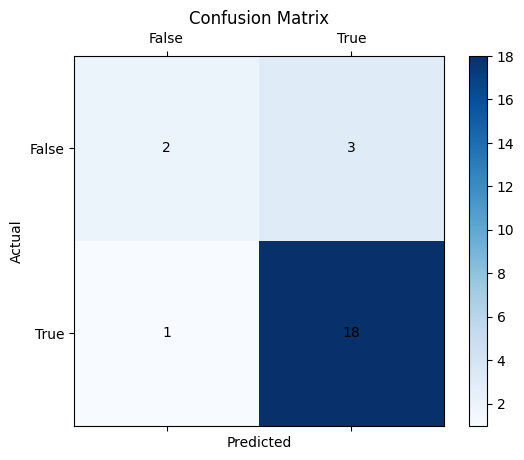

In [11]:
# Erstellen der Confusion Matrix
cm = [[true_negative, false_positive],
      [false_negative, true_positive]]

# Darstellung der Confusion Matrix
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap='Blues')

# Manuelles Hinzufügen der Werte in die Zellen
for i in range(len(cm)):
    for j in range(len(cm[i])):
        ax.text(j, i, str(cm[i][j]), va='center', ha='center')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0, 1], ['False', 'True'])
plt.yticks([0, 1], ['False', 'True'])
plt.colorbar(cax)
plt.show()